In [1]:
from tensorflow import keras

from tensorflow.keras import models, layers  # type: ignore

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
# h0 = 67,45
# omega_m = 0.315


In [23]:
# Preparing the dataset and creating the features and target arrays

n_sims = 1000

x = []
y = []

for i in tqdm(range(n_sims), desc='Carregando dados', ascii=True):
    data = np.load(f'../input/data_{i+1}.npy')
    x.append(data[:, :2])
    y.append(data[0, 2])  # equivalente a data[:, 2:][0][0]

x = np.array(x)
y = np.array(y)

norm = y.max()
# Normalização
y /= y.max()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

Carregando dados: 100%|##########| 1000/1000 [00:12<00:00, 79.06it/s]


In [24]:
# early_stopping = keras.callbacks.EarlyStopping(
#     min_delta=0.001, # minimium amount of change to count as an improvement
#     patience=5, # how many epochs to wait before stopping
#     restore_best_weights=True,
# )

# reduce_lr = keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',   
#     patience=5,          
#     verbose=1,          
#     factor=0.5,          
#     min_lr=0.00001       
# )

learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=5,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)

lr_callback = keras.callbacks.LearningRateScheduler(learning_rate_schedule)


In [34]:
# defining the model


model = models.Sequential()

# model.add()

model.add(layers.Bidirectional(layers.GRU(32,input_shape=(80,2)) ) )


model.add(layers.Flatten())

model.add(layers.Dense(16))
# model.add(layers.Dropout(.3))

model.add(layers.Dense(1))

model.compile(loss=keras.losses.MeanSquaredError(), optimizer='nadam', metrics=keras.metrics.MeanAbsoluteError())


history = model.fit(x_train, y_train, validation_split=.1, epochs=20, batch_size=16, verbose=1, callbacks=[lr_callback])

Epoch 1/20
43/43 [==============================] - 7s 47ms/step - loss: 0.2196 - mean_absolute_error: 0.3151 - val_loss: 0.1645 - val_mean_absolute_error: 0.4021 - lr: 0.0100
Epoch 2/20
43/43 [==============================] - 1s 31ms/step - loss: 0.0820 - mean_absolute_error: 0.2648 - val_loss: 0.0105 - val_mean_absolute_error: 0.0884 - lr: 0.0087
Epoch 3/20
43/43 [==============================] - 1s 31ms/step - loss: 0.0168 - mean_absolute_error: 0.1121 - val_loss: 0.0070 - val_mean_absolute_error: 0.0693 - lr: 0.0076
Epoch 4/20
43/43 [==============================] - 1s 31ms/step - loss: 0.0454 - mean_absolute_error: 0.1183 - val_loss: 0.0027 - val_mean_absolute_error: 0.0458 - lr: 0.0066
Epoch 5/20
43/43 [==============================] - 1s 29ms/step - loss: 0.0034 - mean_absolute_error: 0.0486 - val_loss: 0.0085 - val_mean_absolute_error: 0.0807 - lr: 0.0057
Epoch 6/20
43/43 [==============================] - 1s 31ms/step - loss: 0.0083 - mean_absolute_error: 0.0597 - val_loss

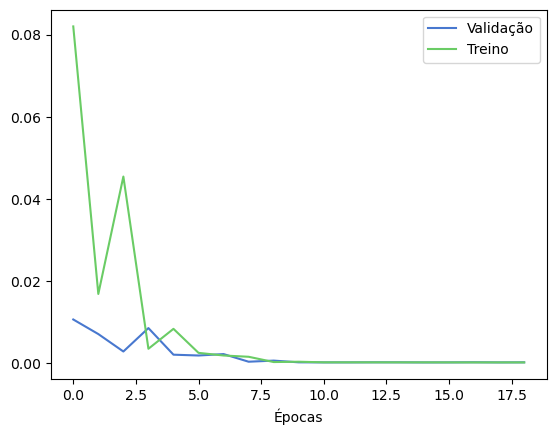

In [35]:
plt.plot(history.history['val_loss'][1:], label='Validação')
plt.plot(history.history['loss'][1:], label='Treino')


plt.xlabel('Épocas')
plt.legend()


plt.savefig("../imagens/loss_h0_rnn_bi")

plt.show()

Dummy variables just for visualization purposes

In [36]:
y_pred = model.predict(x_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

# mse

8/8 [==============================] - 1s 9ms/step


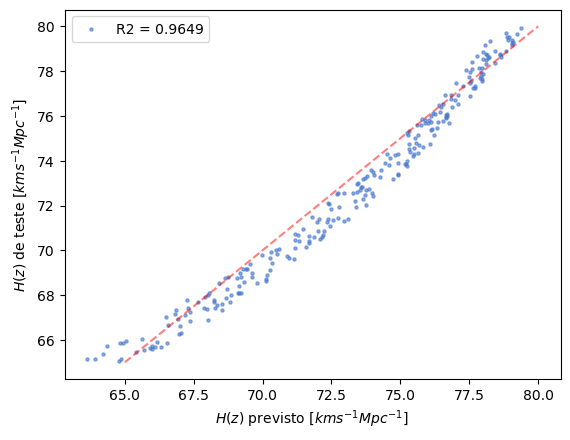

In [37]:
plt.style.use('seaborn-v0_8-muted')

# linha = np.linspace(.3, .35, 2500)
linha = np.linspace(65, 80)

plt.scatter(y_pred*norm, y_test*norm, s=5, alpha=.6, label=f'R2 = {r2:.4f}')
plt.plot(linha, linha, alpha=.5, c='red', ls='--')

plt.legend()


plt.xlabel(r'$H (z)$ previsto [$km s^{-1} Mpc^{-1}$] ')
plt.ylabel(r'$H (z)$ de teste [$km s^{-1} Mpc^{-1}$] ')


plt.savefig("../imagens/metrics_h0_rnn_bi")
plt.show()

In [38]:
# forecasting "real" H(0)

real = np.load('../input/data_real80.npy')
real = real[real[:, 1].argsort()]

real = real.reshape(-1,80,2)

In [39]:

final_real = model.predict(real, verbose=0)

In [40]:
final_real*norm

array([[67.81703]], dtype=float32)

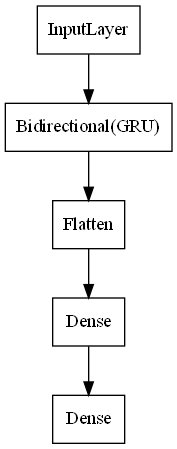

In [41]:
keras.utils.plot_model(model, to_file='../imagens/model_rnn_bi.png', show_shapes=False, show_layer_names=False)


In [42]:
model.save('../models/rnn_bi')

INFO:tensorflow:Assets written to: ../models/rnn_bi\assets


INFO:tensorflow:Assets written to: ../models/rnn_bi\assets
